# Our first Neural Network
Train a generic MLP as binary classifier of protein-coding/non-coding RNA.

In [31]:
import numpy as np
import pandas as pd

## K-mer frequency, K=2

In [32]:
def read_features(nc_file,pc_file):
    nc = pd.read_csv (nc_file)
    pc = pd.read_csv (pc_file)
    nc['class']=0
    pc['class']=1
    rna_mer=pd.concat((nc,pc),axis=0)
    return rna_mer
rna_mer = read_features('ncRNA.2mer.features.csv','pcRNA.2mer.features.csv')
rna_mer

,seqnum,seqlen,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT,class
0,1,535,39,21,38,30,31,48,11,44,31,30,26,28,27,36,40,54,0
1,2,590,37,21,47,27,43,55,9,51,35,42,55,26,18,40,46,37,0
2,3,629,61,30,53,41,48,41,5,45,48,30,31,32,28,38,51,46,0
3,4,1319,109,68,127,77,110,75,16,82,106,79,100,58,57,61,100,93,0
4,5,323,16,21,26,12,28,23,4,21,24,23,31,19,7,9,37,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20147,20148,297,17,24,13,29,22,28,6,36,5,18,6,7,39,22,11,13,1
20148,20149,1378,118,152,47,99,142,147,31,153,36,55,25,21,119,119,34,79,1
20149,20150,1812,170,166,82,132,190,212,40,180,48,81,30,33,142,163,40,102,1
20150,20151,525,18,5,34,46,5,4,8,20,34,13,80,59,45,15,65,73,1


In [33]:
# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = rna_mer.iloc[train_index]
        test_set = rna_mer.iloc[test_index]
    return (train_set,test_set)
(train_set,test_set)=make_train_test(rna_mer)
print("train,test")
train_set.shape,test_set.shape

((30290, 19), (7573, 19))

In [35]:
def prepare_test_set(test_set):
    y_test=   test_set[['class']].copy()
    X_test=   test_set.div(test_set['seqlen'],axis=0)
    X_test=   X_test.drop(columns=['class','seqnum','seqlen'])
    return (X_test,y_test)
(X_test,y_test)=prepare_test_set(test_set)

def prepare_train_set(train_set):
    y_train_all=  train_set[['class']].copy()
    X_train_all=  train_set.div(train_set['seqlen'],axis=0)
    X_train_all=  X_train_all.drop(columns=['class','seqnum','seqlen'])

    from sklearn.model_selection import ShuffleSplit
    splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    for train_index,valid_index in splitter.split(X_train_all):
        X_train=X_train_all.iloc[train_index]
        y_train=y_train_all.iloc[train_index]
        X_valid=X_train_all.iloc[valid_index]
        y_valid=y_train_all.iloc[valid_index]
        
    return (X_train,y_train,X_valid,y_valid)

(X_train,y_train,X_valid,y_valid)=prepare_train_set(train_set)
print("train")
print(X_train.shape,y_train.shape)
print("validate")
print(X_valid.shape,y_valid.shape)

train
(24232, 16) (24232, 1)
validate
(6058, 16) (6058, 1)


In [36]:
# Geron Chapter 10
import tensorflow as tf
from tensorflow import keras
tf.keras.backend.set_floatx('float64')
                            
# We tried all these. No difference.
act="relu" 
act="tanh"
act="sigmoid"

# Adding non-trained Layer Normalization improved accuracy a tiny bit sometimes.
# Adding multiple dense layers only hurt.
mlp2mer = keras.models.Sequential([
    keras.layers.LayerNormalization(trainable=False),
    keras.layers.Dense(32, activation=act,dtype='float32'),
    keras.layers.Dense(32, activation=act,dtype='float32'),
    keras.layers.Dense(1,  activation=act,dtype='float32')
])
# Error:
# ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))
# This was because the output layer had 2 nodes (0 and 1) not 1 (binary).

In [37]:
# See page 302 for explanation of these parameters.
# See also the keras docs e.g. 
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy
# Note keras can take parameters for % train vs % validation.

# It seems the BinaryCrossentropy assumes labels are probabilities.
# Instead of loss="binary_crossentropy",
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
# Tried optimizers SGD, Adam
mlp2mer.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])

# With one dense layer and Adam optimizer, accuracy increases slowly.
history2mer = mlp2mer.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid))

Epoch 1/100
758/758 [==============================] - 3s 4ms/step - loss: 0.6432 - accuracy: 0.6212 - val_loss: 0.6180 - val_accuracy: 0.6603
Epoch 2/100
347/758 [============>.................] - ETA: 0s - loss: 0.6097 - accuracy: 0.6648

KeyboardInterrupt: 

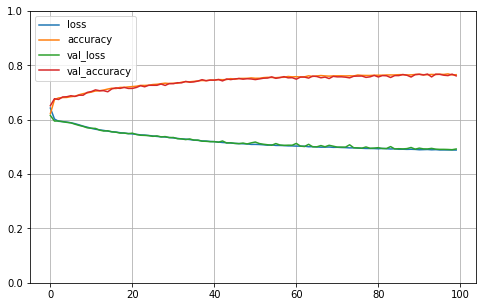

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history2mer.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## K-mer frequency, K=3

In [9]:
nc = pd.read_csv ('ncRNA.3mer.features.csv')
pc = pd.read_csv ('pcRNA.3mer.features.csv')
nc['class']=0
pc['class']=1
rna_mer=pd.concat((nc,pc),axis=0)
bin_labels= sizebin(rna_mer)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
for train_index,test_index in splitter.split(rna3mer,bin_labels):
    train_set = rna3mer.iloc[train_index]
    test_set =  rna3mer.iloc[test_index]
y_train_all=  train_set[['class']].copy()
X_train_all=  train_set.div(train_set['seqlen'],axis=0)
X_train_all=  X_train_all.drop(columns=['class','seqnum','seqlen'])
y_test=   test_set[['class']].copy()
X_test=   test_set.div(test_set['seqlen'],axis=0)
X_test=   X_test.drop(columns=['class','seqnum','seqlen'])
X_train,y_train=X_train_all[:25000],y_train_all[:25000]
X_valid,y_valid=X_train_all[25000:],y_train_all[25000:]

In [10]:
act="sigmoid"
mlp3mer = keras.models.Sequential([
    keras.layers.LayerNormalization(trainable=False),
    keras.layers.Dense(32, activation=act,dtype='float32'),
    keras.layers.Dense(32, activation=act,dtype='float32'),
    keras.layers.Dense(1,  activation=act,dtype='float32')
])
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
mlp3mer.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
history3mer = mlp3mer.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid))

Epoch 1/100
782/782 [==============================] - 3s 3ms/step - loss: 0.6039 - accuracy: 0.6653 - val_loss: 0.5245 - val_accuracy: 0.7457
Epoch 2/100
782/782 [==============================] - 2s 2ms/step - loss: 0.5081 - accuracy: 0.7557 - val_loss: 0.4975 - val_accuracy: 0.7595
Epoch 3/100
782/782 [==============================] - 2s 3ms/step - loss: 0.4928 - accuracy: 0.7647 - val_loss: 0.4926 - val_accuracy: 0.7643
Epoch 4/100
782/782 [==============================] - 3s 4ms/step - loss: 0.4860 - accuracy: 0.7702 - val_loss: 0.4857 - val_accuracy: 0.7645
Epoch 5/100
782/782 [==============================] - 2s 2ms/step - loss: 0.4805 - accuracy: 0.7728 - val_loss: 0.4841 - val_accuracy: 0.7681
Epoch 6/100
782/782 [==============================] - 2s 2ms/step - loss: 0.4769 - accuracy: 0.7764 - val_loss: 0.4840 - val_accuracy: 0.7641
Epoch 7/100
782/782 [==============================] - 2s 2ms/step - loss: 0.4735 - accuracy: 0.7745 - val_loss: 0.4775 - val_accuracy: 0.7679

782/782 [==============================] - 2s 2ms/step - loss: 0.3756 - accuracy: 0.8346 - val_loss: 0.3986 - val_accuracy: 0.8268
Epoch 58/100
782/782 [==============================] - 2s 2ms/step - loss: 0.3746 - accuracy: 0.8347 - val_loss: 0.4015 - val_accuracy: 0.8251
Epoch 59/100
782/782 [==============================] - 2s 2ms/step - loss: 0.3734 - accuracy: 0.8357 - val_loss: 0.3981 - val_accuracy: 0.8287
Epoch 60/100
782/782 [==============================] - 2s 2ms/step - loss: 0.3728 - accuracy: 0.8365 - val_loss: 0.4017 - val_accuracy: 0.8257
Epoch 61/100
782/782 [==============================] - 2s 2ms/step - loss: 0.3723 - accuracy: 0.8349 - val_loss: 0.4033 - val_accuracy: 0.8231
Epoch 62/100
782/782 [==============================] - 2s 2ms/step - loss: 0.3703 - accuracy: 0.8378 - val_loss: 0.3977 - val_accuracy: 0.8284
Epoch 63/100
782/782 [==============================] - 2s 2ms/step - loss: 0.3691 - accuracy: 0.8382 - val_loss: 0.3987 - val_accuracy: 0.8272
Epoch

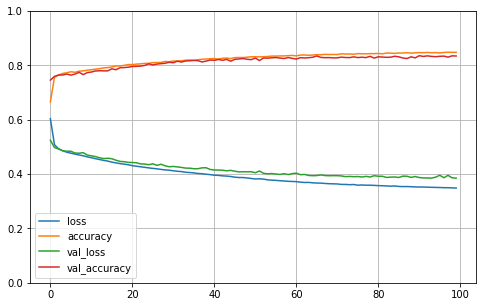

In [11]:
pd.DataFrame(history3mer.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## K-mer frequency, K=4